In [3]:
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import wandb

import tarfile
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms


In [ ]:
import requests

import urllib

testfile = urllib.URLopener()
testfile.retrieve("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", "cifar-100-python.tar.gz")

In [3]:

with tarfile.open("cifar-100-python.tar.gz", 'r|gz') as f:
        f.extractall(path="./")
        f.close()

# Extract cifar-100-python.tar.gz to separate data

In [4]:
data = pickle.load(open(os.path.join("cifar-100-python", "train"), 'rb'), encoding='latin1')
X_train_np = data['data']
y_train_np = np.asarray(data['fine_labels'], np.int8)

data = pickle.load(open(os.path.join('cifar-100-python', 'test'), 'rb'), encoding='latin1')
X_test_np = data['data']
y_test_np = np.asarray(data['fine_labels'], np.int8)

In [5]:
# reshape
X_train_np = X_train_np.reshape(-1, 3, 32, 32)
X_test_np = X_test_np.reshape(-1, 3, 32, 32)


In [28]:
X_train_np.shape

(50000, 3, 32, 32)

d:\skola_fiit\neural_networks_at_fiit\zadanie 2\.env_zadanie2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

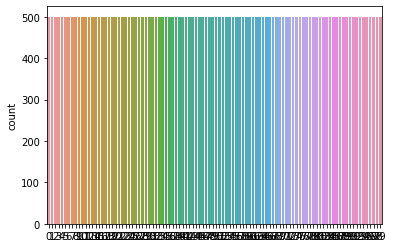

In [29]:
sns.countplot(y_train_np)

NameError: name 'X_train_np' is not defined

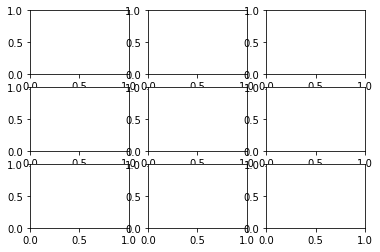

In [8]:
x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(X_train_np[y*y_max+x+offset])
# print(y_train[i])
# plt.imshow(np.rollaxis(X_train[i], 0, 3))

In [9]:
mean = X_train_np.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
std = X_train_np.std(axis=(0,1,2), keepdims=True).astype(np.float32)

X_train_np = (X_train_np - mean) / std
X_test_np = (X_test_np - mean) / std

NameError: name 'X_train_np' is not defined

In [6]:
def train_test_split_v2(X_train,y_train,test_size,random_state=None,sample_limit=None):
    total_count = len(X_train)
    if sample_limit:
        _, X_train, _, y_train = train_test_split(X_train, y_train, test_size=1/(total_count/sample_limit), random_state=random_state)
    return train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [9]:
X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=None, test_size=1/6, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0]+X_valid.shape[0])


(41666, 3, 32, 32)
(8334, 3, 32, 32)
50000


In [89]:
class CIFAR(Dataset):
    def __init__(self, X,y,transform=None):
        self.X=X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = np.rollaxis(self.X[index],0,3)
        label = self.y[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


images shape:  torch.Size([256, 3, 32, 32])
labels shape:  torch.Size([256])


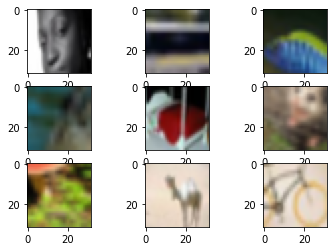

In [99]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32)
])

train_data = CIFAR(X_train,y_train, transform=transform)
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=256)
valid_loader = DataLoader(dataset=valid_data,batch_size=256)


dataiter=iter(train_loader)
images, labels = dataiter.next()

print('images shape: ', images.size())
print('labels shape: ', labels.size())


x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(images[y*y_max+x].permute(1,2,0))

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8192,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class Net(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256,num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [108]:

learning_rate=0.001
betas = (0.9,0.999)
batch_size = 10000
sample_limit = None
epochs = 50


In [101]:

optimizers = [{"name":"Adam","op":optim.Adam},{"name":"RMSprop","op":optim.RMSprop},{"name":"SGD","op":optim.SGD},]
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-4]


Epoch: 1, train loss: 4.6041, valid loss: 4.5998, valid acc: 2.40%
Epoch: 2, train loss: 4.5972, valid loss: 4.6002, valid acc: 1.50%
Epoch: 3, train loss: 4.5975, valid loss: 4.5968, valid acc: 2.20%
Epoch: 4, train loss: 4.5927, valid loss: 4.5949, valid acc: 1.80%
Epoch: 5, train loss: 4.5885, valid loss: 4.5937, valid acc: 2.00%
Epoch: 6, train loss: 4.5869, valid loss: 4.5949, valid acc: 2.10%
Epoch: 7, train loss: 4.5861, valid loss: 4.5907, valid acc: 2.20%
Epoch: 8, train loss: 4.5854, valid loss: 4.5881, valid acc: 2.50%
Epoch: 9, train loss: 4.5866, valid loss: 4.5885, valid acc: 2.30%
Epoch: 10, train loss: 4.5827, valid loss: 4.5865, valid acc: 2.30%
Epoch: 11, train loss: 4.5811, valid loss: 4.5837, valid acc: 2.70%
Epoch: 12, train loss: 4.5759, valid loss: 4.5859, valid acc: 3.10%
Epoch: 13, train loss: 4.5764, valid loss: 4.5813, valid acc: 3.60%
Epoch: 14, train loss: 4.5750, valid loss: 4.5773, valid acc: 4.60%
Epoch: 15, train loss: 4.5714, valid loss: 4.5732, valid 

Train mean loss,4.5255
Valid mean loss,4.54601
Accuracy,7.6
_runtime,1528
_timestamp,1617370107
_step,99


Train mean loss,█▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁
Valid mean loss,██▇▇▆▆▅▄▃▅▄▃▃▃▃▃▂▃▂▃▂▃▃▂▃▂▂▂▂▁▂▂▂▃▁▂▁▁▁▁
Accuracy,▁▁▁▁▂▃▃▄▅▄▆▆▆▆▆▆▆▆▇▆▇▆▆▇▆▆▇▆▇█▇▇▇▆█▆████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


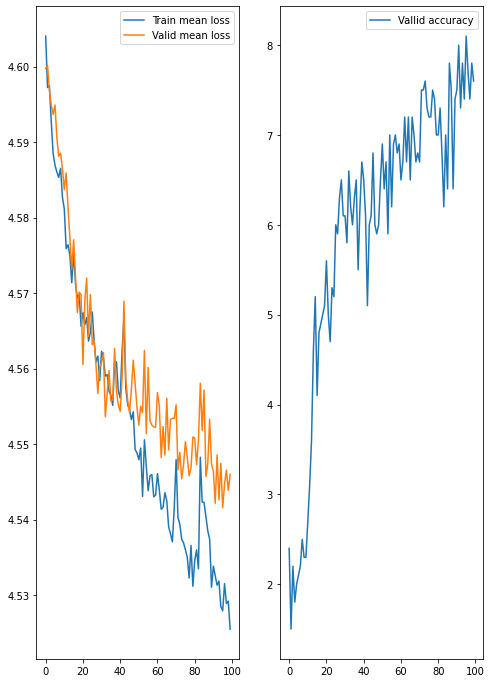

In [103]:

trfs = [
    # {"name":"No transform", "tr":transforms.ToTensor()},
    # {
    #     "name":"Normalize",
    #     "tr": transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #     ]),
    #     "tr_v": transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    #     ])
    # },
    {
        "name":"Random crop",
        "tr":transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(32)
        ]),
        "tr_v": transforms.Compose([
            transforms.ToTensor()
        ])
    },
    {
        "name":"Norm + Crop",
        "tr":transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.RandomResizedCrop(32)
        ]),
        "tr_v": transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    },
    {
        "name":"RandFlip + Norm + Crop",
        "tr":transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.RandomResizedCrop(32)
        ]),
        "tr_v": transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
    }
]

d:\skola_fiit\neural_networks_at_fiit\zadanie 2\.env_zadanie2\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
d:\skola_fiit\neural_networks_at_fiit\zadanie 2\.env_zadanie2\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1, train loss: 4.6033, valid loss: 4.6024, valid acc: 1.19%
Epoch: 2, train loss: 4.5941, valid loss: 4.6040, valid acc: 1.68%
Epoch: 3, train loss: 4.5912, valid loss: 4.6029, valid acc: 1.66%
Epoch: 4, train loss: 4.5903, valid loss: 4.6003, valid acc: 1.60%
Epoch: 5, train loss: 4.5898, valid loss: 4.5946, valid acc: 2.23%
Epoch: 6, train loss: 4.5881, valid loss: 4.5974, valid acc: 2.08%
Epoch: 7, train loss: 4.5868, valid loss: 4.5912, valid acc: 2.60%
Epoch: 8, train loss: 4.5830, valid loss: 4.6004, valid acc: 1.72%
Epoch: 9, train loss: 4.5810, valid loss: 4.5884, valid acc: 3.05%
Epoch: 10, train loss: 4.5764, valid loss: 4.5819, valid acc: 3.65%
Epoch: 11, train loss: 4.5740, valid loss: 4.5845, valid acc: 3.50%
Epoch: 12, train loss: 4.5701, valid loss: 4.5749, valid acc: 4.28%
Epoch: 13, train loss: 4.5652, valid loss: 4.5699, valid acc: 5.00%
Epoch: 14, train loss: 4.5619, valid loss: 4.5762, valid acc: 4.40%
Epoch: 15, train loss: 4.5595, valid loss: 4.5742, valid 

Train mean loss,4.47078
Valid mean loss,4.51988
Accuracy,10.16319
_runtime,4939
_timestamp,1617383923
_step,49


Train mean loss,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid mean loss,█████▇█▇▇▆▆▆▆▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▂▂▂▁▂
Accuracy,▁▁▁▁▂▂▁▂▂▃▃▃▄▄▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇██▇▇▇█▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


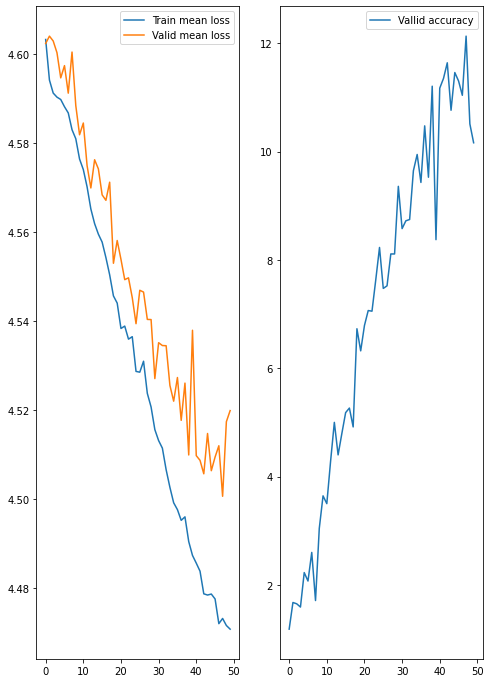

In [109]:
optimizers = [{"name":"Adam","op":optim.Adam},{"name":"RMSProp","op":optim.RMSprop},{"name":"SGD","op":optim.SGD},]
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-4]


run = wandb.init(project='Zadanie2-CIFAR', entity='xpetricko')
run.name = "Full run 50 epochs 10000 bs"

config = wandb.config
config.learning_rate = learning_rate
config.sample_limit=sample_limit
config.batch_size=batch_size


model = Net(3,100)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# optimizer = opt["op"](model.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

wandb.watch(model)

X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=sample_limit, test_size=1/6, random_state=7)

train_data = CIFAR(X_train,y_train, transform=transforms.ToTensor())
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=batch_size)
valid_loader = DataLoader(dataset=valid_data,batch_size=batch_size)

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []


torch.manual_seed(7)

for epoch in range(epochs):
    model.train()

    train_losses = []
    valid_losses = []

    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model.forward(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()


        train_losses.append(loss.item())


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i,(images,labels) in enumerate(valid_loader):
            output = model.forward(images)
            loss = loss_fn(output,labels)

            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data,1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)

    wandb.log({"Train mean loss":mean_train_losses[-1],"Valid mean loss":mean_valid_losses[-1],"Accuracy":accuracy})

    print('Epoch: {}, train loss: {:.4f}, valid loss: {:.4f}, valid acc: {:.2f}%'.format(epoch+1,mean_train_losses[-1],mean_valid_losses[-1],accuracy))

run.finish()


    #%%

fig, (plot1,plot2) = plt.subplots(nrows=1,ncols=2,figsize=(8,12))
plot1.plot(mean_train_losses, label="Train mean loss")
plot1.plot(mean_valid_losses, label="Valid mean loss")
plot1.legend(loc="best")

plot2.plot(valid_acc_list,label="Vallid accuracy")
plot2.legend()